In [15]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy

In [17]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [18]:
ratings_df = pd.read_csv("C:/Users/User/Downloads/FYPBookRecommendation/Ratings_100k.csv")

print("Dataset shape:", ratings_df.shape)
print("\nFirst few rows:")
print(ratings_df.head())
print("\nDataset info:")
print(ratings_df.info())
print("\nBasic statistics:")
print(ratings_df.describe())


Dataset shape: (100000, 3)

First few rows:
   User-ID        ISBN  Book-Rating
0    38781  0373259131            0
1   128835  0811805905            8
2   261829  037324486X            0
3   247747  0531303306            0
4    74076  0316812404            0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      100000 non-null  int64 
 1   ISBN         100000 non-null  object
 2   Book-Rating  100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB
None

Basic statistics:
             User-ID    Book-Rating
count  100000.000000  100000.000000
mean   140079.443660       2.851320
std     80462.805274       3.849117
min         8.000000       0.000000
25%     69971.000000       0.000000
50%    140292.000000       0.000000
75%    210485.000000       7.000000
max    278854.000000      10.000000


Number of ratings: 100000
Number of unique books (ISBN): 63194
Number of unique users: 25386

Rating distribution:
Book-Rating
0     62462
1       156
2       242
3       545
4       764
5      4472
6      3187
7      6542
8      8970
9      5835
10     6825
Name: count, dtype: int64


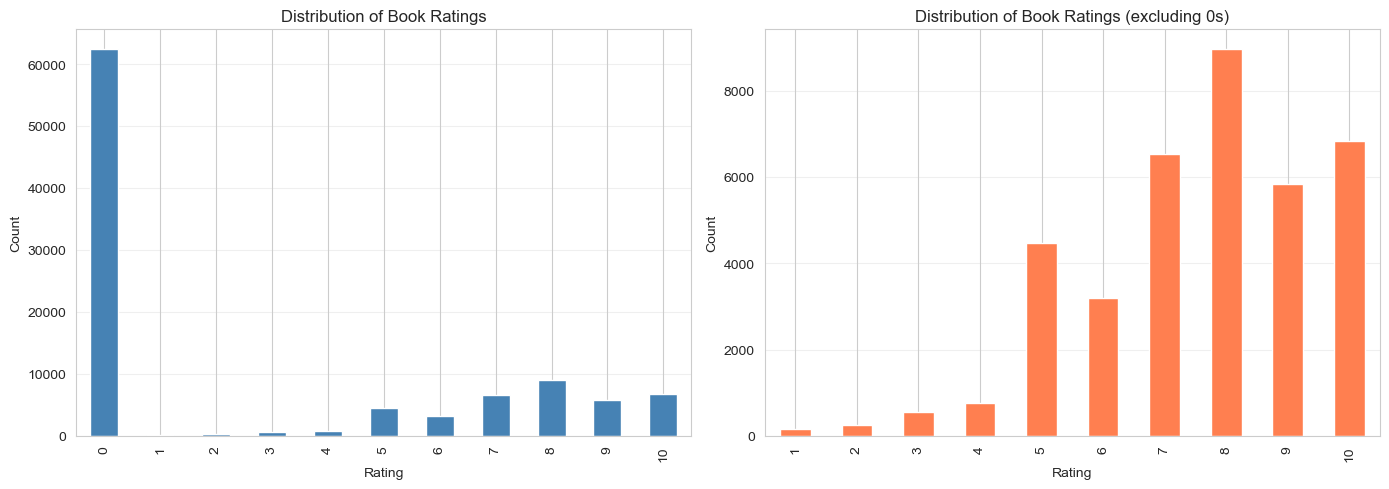

In [19]:
# Data exploration
print('Number of ratings:', len(ratings_df))
print('Number of unique books (ISBN):', ratings_df['ISBN'].nunique())
print('Number of unique users:', ratings_df['User-ID'].nunique())
print('\nRating distribution:')
print(ratings_df['Book-Rating'].value_counts().sort_index())

# Visualize rating distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overall rating distribution
ratings_df['Book-Rating'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Distribution of Book Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# Rating distribution (excluding 0 ratings if they exist)
non_zero_ratings = ratings_df[ratings_df['Book-Rating'] > 0]['Book-Rating']
non_zero_ratings.value_counts().sort_index().plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Distribution of Book Ratings (excluding 0s)')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for Surprise library
# Define rating scale (adjust based on your data)
# Common book rating scales are 0-10 or 1-5
rating_scale = (ratings_df['Book-Rating'].min(), ratings_df['Book-Rating'].max())
print(f"Rating scale: {rating_scale}")

# Create Reader object
reader = Reader(rating_scale=rating_scale)

# Load data into Surprise Dataset
data = Dataset.load_from_df(ratings_df[['User-ID', 'ISBN', 'Book-Rating']], reader)

print("\n✅ Data loaded successfully for Surprise library")

Rating scale: (0, 10)


KeyError: "['User_ID'] not in index"

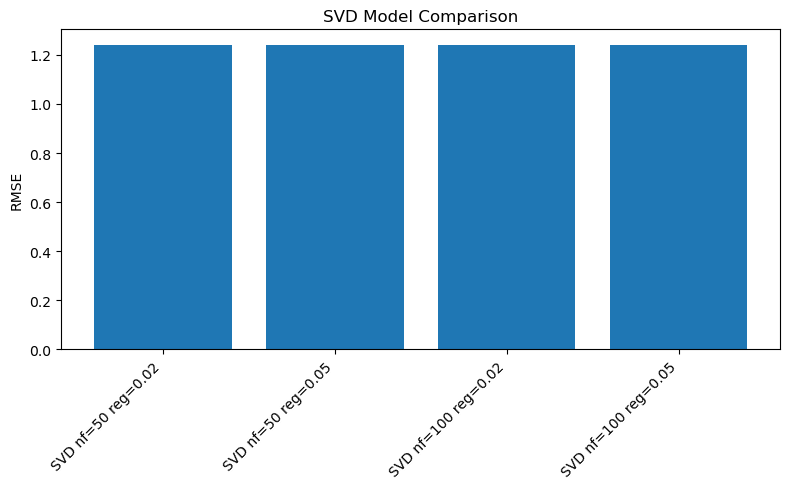

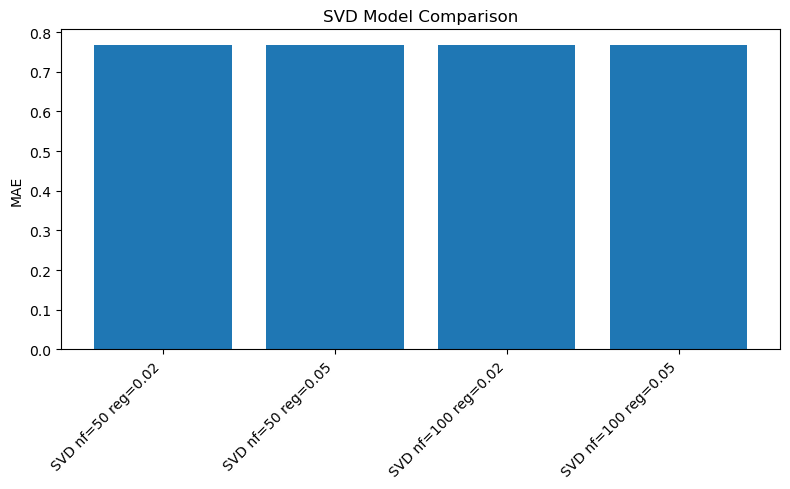

In [ ]:
# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

print(f"Training set size: {trainset.n_ratings}")
print(f"Test set size: {len(testset)}")

In [ ]:
# Train initial SVD model with default parameters
print("Training SVD model with default parameters...")
svd_model = SVD(random_state=RANDOM_SEED)
svd_model.fit(trainset)

# Make predictions on test set
predictions = svd_model.test(testset)

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

print(f"\nInitial Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Best RMSE: 1.23998012987845
Best params for RMSE: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.05}
Best MAE: 0.7647570640409164
Best params for MAE: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}


In [ ]:
print("\nPerforming 5-fold cross-validation...")
cv_results = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nCross-Validation Results:")
print(f"Mean RMSE: {cv_results['test_rmse'].mean():.4f} (+/- {cv_results['test_rmse'].std():.4f})")
print(f"Mean MAE: {cv_results['test_mae'].mean():.4f} (+/- {cv_results['test_mae'].std():.4f})")

RMSE: 1.2380
MAE:  0.7698


In [ ]:
# Hyperparameter tuning with GridSearchCV
print("\nPerforming hyperparameter tuning...")

param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

print("\nBest RMSE score:", gs.best_score['rmse'])
print("Best parameters for RMSE:", gs.best_params['rmse'])
print("\nBest MAE score:", gs.best_score['mae'])
print("Best parameters for MAE:", gs.best_params['mae'])

    userId  itemId  actual_rating  pred_rating  pred_rating_round   abs_err
0  1995523   80675            5.0     4.704503                  5  0.295497
1    68884  181844            4.0     4.437072                  4  0.437072
2   760391   42877            5.0     4.330401                  4  0.669599
3   358681   40029            4.0     4.569575                  5  0.569575
4  1105991  462859            5.0     4.729886                  5  0.270114


C:\Users\HELIOS NEO\AppData\Local\Temp\ipykernel_67168\192084720.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\HELIOS NEO\AppData\Local\Temp\ipykernel_67168\192084720.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


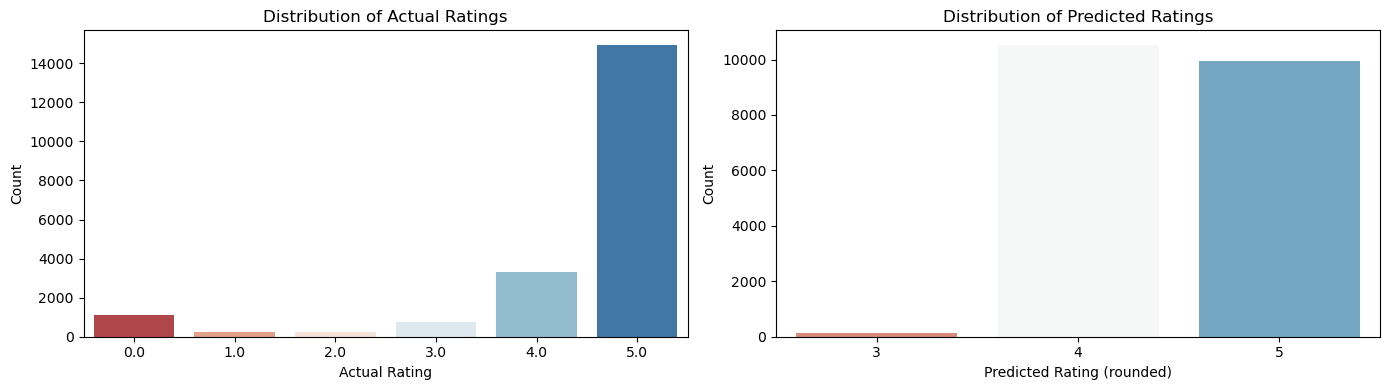

In [ ]:
# Train final model with best parameters
best_params = gs.best_params['rmse']
print(f"\nTraining final model with best parameters: {best_params}")

final_model = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=RANDOM_SEED
)

# Train on full trainset
final_model.fit(trainset)

# Evaluate on test set
final_predictions = final_model.test(testset)
final_rmse = accuracy.rmse(final_predictions)
final_mae = accuracy.mae(final_predictions)

print(f"\nFinal Model Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")

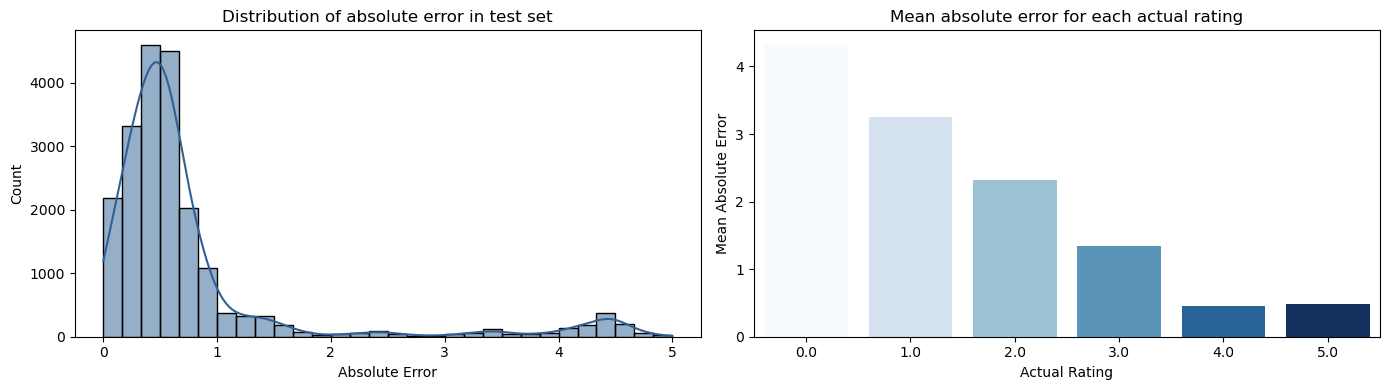

In [ ]:
# Convert predictions to DataFrame for analysis
pred_df = pd.DataFrame([{
    'User_ID': pred.uid,
    'ISBN': pred.iid,
    'actual_rating': pred.r_ui,
    'predicted_rating': pred.est,
    'predicted_rating_rounded': round(pred.est),
    'absolute_error': abs(pred.est - pred.r_ui)
} for pred in final_predictions])

print("Predictions DataFrame shape:", pred_df.shape)
print("\nFirst few predictions:")
print(pred_df.head(10))
print("\nPrediction statistics:")
print(pred_df[['actual_rating', 'predicted_rating', 'absolute_error']].describe())

In [ ]:
# Visualize prediction results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted ratings distribution
ax1, ax2 = axes[0]
pred_df['actual_rating'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Distribution of Actual Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')

pred_df['predicted_rating_rounded'].value_counts().sort_index().plot(kind='bar', ax=ax2, color='coral', alpha=0.7)
ax2.set_title('Distribution of Predicted Ratings (Rounded)')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Count')

# 3. Absolute error distribution
ax3 = axes[1, 0]
pred_df['absolute_error'].hist(bins=30, ax=ax3, color='green', alpha=0.7, edgecolor='black')
ax3.set_title('Distribution of Absolute Error')
ax3.set_xlabel('Absolute Error')
ax3.set_ylabel('Frequency')

# 4. Mean absolute error by rating
ax4 = axes[1, 1]
error_by_rating = pred_df.groupby('actual_rating')['absolute_error'].mean().sort_index()
error_by_rating.plot(kind='bar', ax=ax4, color='purple', alpha=0.7)
ax4.set_title('Mean Absolute Error by Actual Rating')
ax4.set_xlabel('Actual Rating')
ax4.set_ylabel('Mean Absolute Error')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze a specific user's predictions
def analyze_user_predictions(user_id, pred_df, top_n=10):
    """
    Analyze predictions for a specific user
    """
    user_preds = pred_df[pred_df['User_ID'] == user_id].copy()
    
    if len(user_preds) == 0:
        print(f"No predictions found for User {user_id}")
        return None
    
    print(f"\n{'='*60}")
    print(f"Analysis for User {user_id}")
    print(f"{'='*60}")
    print(f"Number of predictions: {len(user_preds)}")
    print(f"\nActual rating distribution:")
    print(user_preds['actual_rating'].value_counts().sort_index())
    print(f"\nPredicted rating distribution (rounded):")
    print(user_preds['predicted_rating_rounded'].value_counts().sort_index())
    print(f"\nMean Absolute Error: {user_preds['absolute_error'].mean():.4f}")
    print(f"\nTop {top_n} predictions:")
    print(user_preds.nlargest(top_n, 'predicted_rating')[['ISBN', 'actual_rating', 'predicted_rating', 'absolute_error']])
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    user_preds['actual_rating'].value_counts().sort_index().plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_title(f'Actual Ratings for User {user_id}')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    
    user_preds['predicted_rating_rounded'].value_counts().sort_index().plot(kind='bar', ax=ax2, color='coral')
    ax2.set_title(f'Predicted Ratings for User {user_id}')
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return user_preds

# Example: Analyze a random user
sample_user = pred_df['User_ID'].iloc[0]
user_analysis = analyze_user_predictions(sample_user, pred_df)

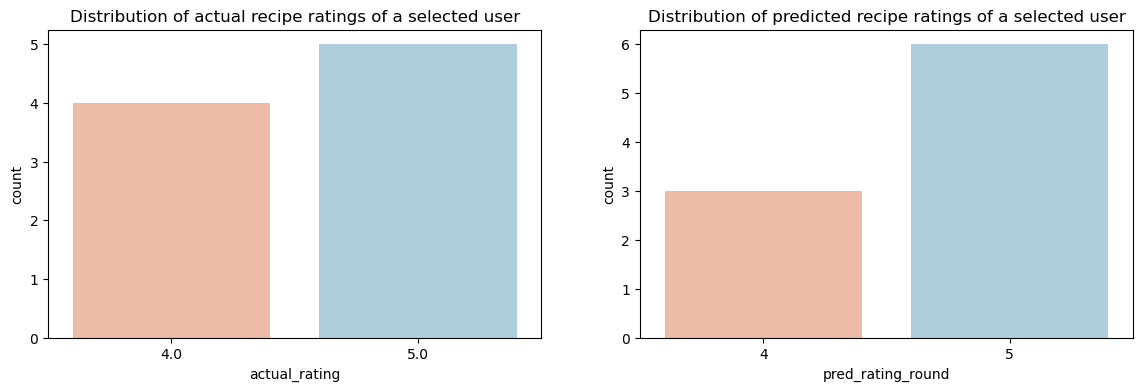

Counts of ratings for user 68884
     Actual  Predicted
4.0       4          3
5.0       5          6


In [ ]:
# Generate recommendations for a specific user
def get_recommendations(user_id, model, ratings_df, n_recommendations=10):
    """
    Generate top N book recommendations for a user
    """
    # Get all unique books
    all_books = ratings_df['ISBN'].unique()
    
    # Get books the user has already rated
    user_rated_books = ratings_df[ratings_df['User_ID'] == user_id]['ISBN'].values
    
    # Get books the user hasn't rated
    unrated_books = [book for book in all_books if book not in user_rated_books]
    
    # Generate predictions for unrated books
    predictions = []
    for book in unrated_books:
        pred = model.predict(user_id, book)
        predictions.append((book, pred.est))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Return top N recommendations
    recommendations = predictions[:n_recommendations]
    
    return recommendations

# Example: Get recommendations for a user
sample_user_id = ratings_df['User_ID'].iloc[100]  # Pick a user
print(f"\nGenerating recommendations for User {sample_user_id}...")

# Check what this user has rated
user_ratings = ratings_df[ratings_df['User_ID'] == sample_user_id]
print(f"\nUser has rated {len(user_ratings)} books")
print(f"Average rating: {user_ratings['Book-Rating'].mean():.2f}")

# Get recommendations
recommendations = get_recommendations(sample_user_id, final_model, ratings_df, n_recommendations=10)

print(f"\nTop 10 Recommended Books (ISBN) for User {sample_user_id}:")
print("-" * 60)
for i, (isbn, predicted_rating) in enumerate(recommendations, 1):
    print(f"{i}. ISBN: {isbn} - Predicted Rating: {predicted_rating:.2f}")

In [ ]:
# Save the trained model and predictions
import pickle
import os

save_dir = "./Pickle"
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_path = os.path.join(save_dir, "book_cf_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(final_model, f)

print(f"✅ Model saved to {model_path}")

# Save predictions
predictions_path = os.path.join(save_dir, "book_predictions.csv")
pred_df.to_csv(predictions_path, index=False)
print(f"✅ Predictions saved to {predictions_path}")

# Save model parameters for reference
params_df = pd.DataFrame([best_params])
params_path = os.path.join(save_dir, "model_parameters.csv")
params_df.to_csv(params_path, index=False)
print(f"✅ Model parameters saved to {params_path}")

[   1995523      68884     760391     358681    1105991     340141
 2001697370    1072593    1374437    1577274     237123     167140
     883903     174991      60716     694658     326235       9580
    1024982     337963]


In [ ]:
# Performance summary
print("\n" + "="*60)
print("COLLABORATIVE FILTERING MODEL - PERFORMANCE SUMMARY")
print("="*60)
print(f"Dataset: Rating_100k.csv")
print(f"Total ratings: {len(ratings_df)}")
print(f"Unique users: {ratings_df['User_ID'].nunique()}")
print(f"Unique books: {ratings_df['ISBN'].nunique()}")
print(f"\nRating scale: {rating_scale}")
print(f"\nBest Model Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nModel Performance:")
print(f"  RMSE: {final_rmse:.4f}")
print(f"  MAE: {final_mae:.4f}")
print(f"\nModel saved to: {model_path}")
print("="*60)

User 163083 rated 'Hamburger Hash Browns Hotdish' with 5 stars.

Top 5 recommended recipes for user 163083:
Yummy Bread Pudding — Predicted Rating: 5.00
Mexican Stack-Up #RSC — Predicted Rating: 5.00
Beauty Parlor Garlic Bread — Predicted Rating: 5.00
Teriyaki Glaze Marinade — Predicted Rating: 4.99
Grandma's Hush Puppies — Predicted Rating: 4.95
